In [9]:
import os

import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import cv2

import json

current_directory = os.getcwd()

## Load ScanNet scene

In [10]:
scan = "scene0000_00"

scan_path = os.path.join(current_directory, "data/scans", scan)
scene_mesh_path = os.path.join(scan_path, scan + "_vh_clean_2.ply")
scene_mesh = o3d.io.read_triangle_mesh(scene_mesh_path )

# o3d.visualization.draw_geometries([scene_mesh])

## Select a class

The class must be chosen among one of the raw_category in the [scannetv2-labels.combinesd.tsv](data/scannetv2-labels.combined.tsv)

In [11]:
with open(os.path.join(scan_path, scan + '.aggregation.json')) as f:
    aggregation_data = json.load(f)

all_classes = set()
for seg_group in aggregation_data['segGroups']:
    all_classes.add(seg_group['label'])

print("All labels in the aggregation data: ", all_classes)

All labels in the aggregation data:  {'clock', 'curtain', 'couch', 'ceiling', 'shelf', 'kitchen counter', 'doorframe', 'tv', 'object', 'refrigerator', 'wall', 'desk', 'toilet', 'coffee table', 'guitar', 'tissue box', 'toaster', 'floor', 'window', 'scale', 'backpack', 'kitchen cabinets', 'door', 'nightstand', 'trash can', 'cabinet', 'bicycle', 'sink', 'toaster oven', 'shoes', 'microwave', 'dish rack', 'stool', 'bed', 'table', 'shower', 'mirror', 'guitar case', 'laundry basket', 'pillow'}


In [12]:
class_name = 'bed'

with open(os.path.join(scan_path, scan + '.aggregation.json')) as f:
    aggregation_data = json.load(f)

object_ids = []
for seg_group in aggregation_data['segGroups']:
    if seg_group['label'] == class_name:
        object_ids.append(seg_group['objectId'])

if not object_ids:
    print("No objects found for class:", class_name)
else:
    print(f"Found {len(object_ids)} objects for class {class_name}: {object_ids}")


Found 1 objects for class bed: [37]


## Select an object

In [13]:
object_id = 37

other_objects = []
for seg_group in aggregation_data['segGroups']:
    if seg_group['objectId'] == object_id:
        selected_instance_segments = seg_group['segments']
    else:
        object_instance_segments = seg_group['segments']
        other_objects.append(object_instance_segments)

# Load over-segmentation data
with open(os.path.join(scan_path, scan + '_vh_clean_2.0.010000.segs.json')) as f:
    segmentation_data = json.load(f)

# Map from vertex index to segment ID
vertex_to_segment = np.array(segmentation_data['segIndices'])

# Filter vertices based on whether their segment ID is in the selected instance segments
instance_vertices_mask = np.isin(vertex_to_segment, selected_instance_segments)
instance_vertex_indices = np.where(instance_vertices_mask)[0]

# Filter faces of the mesh. A face is included if all its vertices are part of the instance
faces = np.asarray(scene_mesh.triangles)
face_mask = np.all(np.isin(faces, instance_vertex_indices), axis=1)
instance_faces = faces[face_mask]

# Create a new mesh for the instance
instance_vertices = np.asarray(scene_mesh.vertices)[instance_vertex_indices]

# Remap the vertices indices in the faces to their new indices
vertex_remap = {old_idx: new_idx for new_idx, old_idx in enumerate(instance_vertex_indices)}
instance_faces_remap = np.vectorize(vertex_remap.get)(instance_faces)

# Create the mesh for the selected instance
instance_mesh = o3d.geometry.TriangleMesh()
instance_mesh.vertices = o3d.utility.Vector3dVector(instance_vertices)
instance_mesh.triangles = o3d.utility.Vector3iVector(instance_faces_remap)

# Repeat the process for all objects in the scene
other_objects_meshes = []
for segments in other_objects:
    object_vertices_mask = np.isin(vertex_to_segment, segments)
    object_vertex_indices = np.where(object_vertices_mask)[0]

    object_face_mask = np.all(np.isin(faces, object_vertex_indices), axis=1)
    object_faces = faces[object_face_mask]

    object_vertices = np.asarray(scene_mesh.vertices)[object_vertex_indices]
    object_vertex_remap = {old_idx: new_idx for new_idx, old_idx in enumerate(object_vertex_indices)}
    object_faces_remap = np.vectorize(object_vertex_remap.get)(object_faces)

    object_mesh = o3d.geometry.TriangleMesh()
    object_mesh.vertices = o3d.utility.Vector3dVector(object_vertices)
    object_mesh.triangles = o3d.utility.Vector3iVector(object_faces_remap)
    other_objects_meshes.append(object_mesh)

# o3d.visualization.draw_geometries([instance_mesh])

## Select frames that contain the specific object

### Export camera parameters
**Note:** This step should be performed only at the beginning of the process.

In [6]:
reader_directory = os.path.join(current_directory, "scripts/SensReader")
sens_file = os.path.join(scan_path, scan + ".sens")
output_directory = os.path.join(current_directory, "outputs/reader/"+scan)

os.system(f"python {os.path.join(reader_directory, 'reader.py')} --filename {sens_file} --output_path {output_directory} --export_color_images --export_poses --export_intrinsics")

Namespace(filename='/Users/lara/Desktop/Making-CLIP-features-multiview-consistent/data/scans/scene0000_00/scene0000_00.sens', output_path='/Users/lara/Desktop/Making-CLIP-features-multiview-consistent/outputs/reader/scene0000_00', export_depth_images=False, export_color_images=True, export_poses=True, export_intrinsics=True)
loading /Users/lara/Desktop/Making-CLIP-features-multiview-consistent/data/scans/scene0000_00/scene0000_00.sens...loaded!
exporting 5578 color frames to /Users/lara/Desktop/Making-CLIP-features-multiview-consistent/outputs/reader/scene0000_00/color
exporting 5578 camera poses to /Users/lara/Desktop/Making-CLIP-features-multiview-consistent/outputs/reader/scene0000_00/pose
exporting camera intrinsics to /Users/lara/Desktop/Making-CLIP-features-multiview-consistent/outputs/reader/scene0000_00/intrinsic


0

### Select minimum_points in an image

In [14]:
minimum_points = 10000

## Example

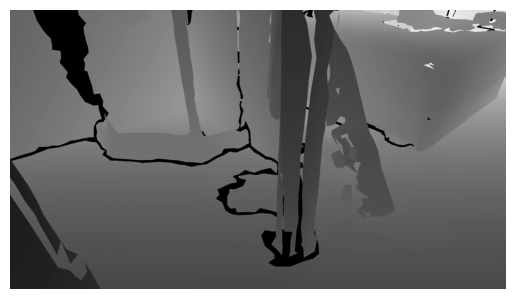

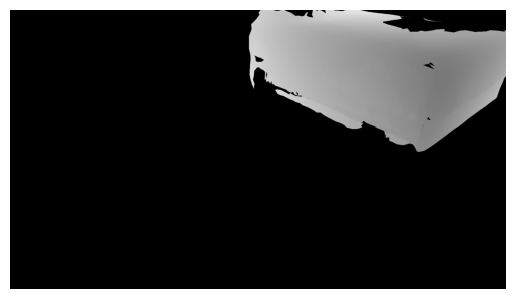

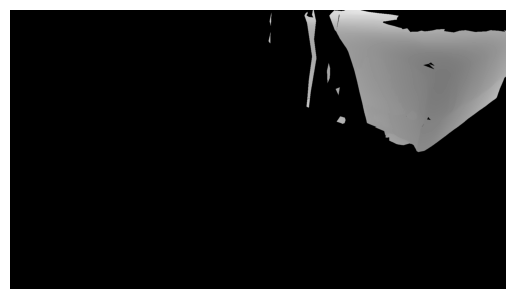

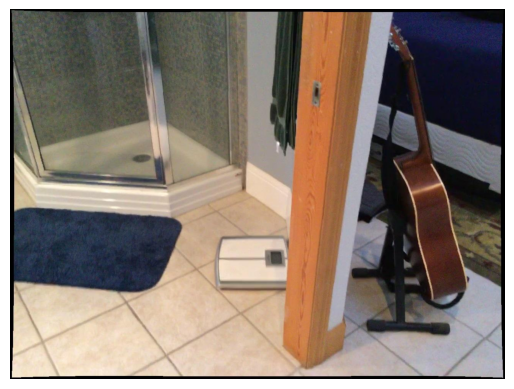

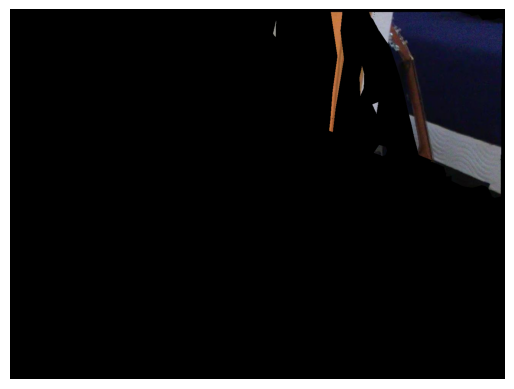

In [15]:
output_directory = os.path.join(current_directory, "outputs/reader/"+scan)
pose_directory = os.path.join(output_directory, "pose")
originals_directory = os.path.join(output_directory, "color")
pose_files = [f for f in os.listdir(pose_directory) if f.endswith('.txt')]
frame_indices = [int(f.split('.')[0]) for f in pose_files]
intrinsics = np.loadtxt(os.path.join(output_directory, "intrinsic", "intrinsic_color.txt"))  # Camera intrinsics
extrinsics = np.loadtxt(os.path.join(output_directory, "intrinsic", "extrinsic_color.txt"))  # Camera estrinsic
camera_intrinsics = intrinsics[:3, :3]

output_directory = os.path.join(current_directory, "outputs/reader/"+scan)
originals_directory = os.path.join(output_directory, "color")
original_path = os.path.join(originals_directory, "0.jpg") # image used to get the image shape
original = cv2.imread(original_path)
image_height, image_width = original.shape[:2]

pose_path = os.path.join(pose_directory, "4070.txt")
original_path = os.path.join(originals_directory, "4070.jpg")
pose = np.loadtxt(pose_path)
original = cv2.imread(original_path)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

# Get camera parameters
camera_extrinsics = np.linalg.inv(pose)
intrinsic = o3d.camera.PinholeCameraIntrinsic()
intrinsic.set_intrinsics(width=image_width, height=image_height, fx=camera_intrinsics[0][0], fy=camera_intrinsics[1][1], cx=camera_intrinsics[0][2], cy=camera_intrinsics[1][2])
camera = o3d.camera.PinholeCameraParameters()
camera.extrinsic = np.array(camera_extrinsics)
camera.intrinsic = intrinsic

# Get depth image with all objects
complete_vis = o3d.visualization.Visualizer()
complete_vis.create_window(visible=False)
for object in other_objects_meshes:
    complete_vis.add_geometry(object)
complete_vis.add_geometry(instance_mesh)
complete_vis.get_view_control().convert_from_pinhole_camera_parameters(camera, True)
depth = complete_vis.capture_depth_float_buffer(do_render=True)
depth_image = np.asarray(depth)
complete_vis.destroy_window()

plt.imshow(depth_image, cmap='gray')
plt.axis('off')
plt.show()

# Get depth image with instance object
instance_vis = o3d.visualization.Visualizer()
instance_vis.create_window(visible=False)
instance_vis.add_geometry(instance_mesh)
instance_vis.get_view_control().convert_from_pinhole_camera_parameters(camera, True)
depth = instance_vis.capture_depth_float_buffer(do_render=True)
instance_depth_image = np.asarray(depth)
instance_vis.destroy_window()

plt.imshow(instance_depth_image, cmap='gray')
plt.axis('off')
plt.show()

non_black_pixels = instance_depth_image > 0

# Get depth image with instance object occluded
tolerance = 1e-3
darker_pixels = np.logical_and(non_black_pixels, instance_depth_image > depth_image + tolerance)
instance_depth_image[darker_pixels] = 0

# Display the modified instance depth image
plt.imshow(instance_depth_image, cmap='gray')
plt.axis('off')
plt.show()

# Calculate the center of the instance depth image
center_y, center_x = instance_depth_image.shape[0] // 2, instance_depth_image.shape[1] // 2

# Determine the top left corner of the cropping area
start_x = center_x - (original.shape[1] // 2)
start_y = center_y - (original.shape[0] // 2)

# Crop the instance depth image to match the original image size
cropped_instance_depth_image = instance_depth_image[start_y:start_y + original.shape[0], start_x:start_x + original.shape[1]]

# Create a mask where the cropped depth image has values greater than zero
mask = cropped_instance_depth_image > 0

# Apply the mask to the original image
masked_original = original.copy()
masked_original[~mask] = 0  # Set pixels to black where mask is False

# Display the masked original image
plt.imshow(original)
plt.axis('off')
plt.show()

# Display the masked original image
plt.imshow(masked_original)
plt.axis('off')
plt.show()

## Get masked images

In [16]:
output_directory = os.path.join(current_directory, "outputs/reader/"+scan)
pose_directory = os.path.join(output_directory, "pose")
originals_directory = os.path.join(output_directory, "color")
pose_files = [f for f in os.listdir(pose_directory) if f.endswith('.txt')]
frame_indices = [int(f.split('.')[0]) for f in pose_files]
intrinsics = np.loadtxt(os.path.join(output_directory, "intrinsic", "intrinsic_color.txt"))  # Camera intrinsics
extrinsics = np.loadtxt(os.path.join(output_directory, "intrinsic", "extrinsic_color.txt"))  # Camera estrinsic
camera_intrinsics = intrinsics[:3, :3]

output_directory = os.path.join(current_directory, "outputs/reader/"+scan)
originals_directory = os.path.join(output_directory, "color")
original_path = os.path.join(originals_directory, "0.jpg") # image used to get the image shape
original = cv2.imread(original_path)
image_height, image_width = original.shape[:2]

selected_frames = []
masked_images_directory = os.path.join(current_directory, "outputs/masked_images/project_occluded/"+scan, f"{object_id}")
if not os.path.exists(masked_images_directory):
    os.makedirs(masked_images_directory)

for frame_index in frame_indices:
    pose_path = os.path.join(pose_directory, f"{frame_index}.txt")
    original_path = os.path.join(originals_directory, f"{frame_index}.jpg")
    pose = np.loadtxt(pose_path)
    original = cv2.imread(original_path)
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    # Get camera parameters
    camera_extrinsics = np.linalg.inv(pose)
    intrinsic = o3d.camera.PinholeCameraIntrinsic()
    intrinsic.set_intrinsics(width=image_width, height=image_height, fx=camera_intrinsics[0][0], fy=camera_intrinsics[1][1], cx=camera_intrinsics[0][2], cy=camera_intrinsics[1][2])
    camera = o3d.camera.PinholeCameraParameters()
    camera.extrinsic = np.array(camera_extrinsics)
    camera.intrinsic = intrinsic

    # Get depth image with all objects
    complete_vis = o3d.visualization.Visualizer()
    complete_vis.create_window(visible=False)
    for object in other_objects_meshes:
        complete_vis.add_geometry(object)
    complete_vis.add_geometry(instance_mesh)
    complete_vis.get_view_control().convert_from_pinhole_camera_parameters(camera, True)
    depth = complete_vis.capture_depth_float_buffer(do_render=True)
    depth_image = np.asarray(depth)
    complete_vis.destroy_window()

    # Get depth image with instance object
    instance_vis = o3d.visualization.Visualizer()
    instance_vis.create_window(visible=False)
    instance_vis.add_geometry(instance_mesh)
    instance_vis.get_view_control().convert_from_pinhole_camera_parameters(camera, True)
    depth = instance_vis.capture_depth_float_buffer(do_render=True)
    instance_depth_image = np.asarray(depth)
    instance_vis.destroy_window()

    non_black_pixels = instance_depth_image > 0

    # Get depth image with instance object occluded
    tolerance = 1e-3
    darker_pixels = np.logical_and(non_black_pixels, instance_depth_image > depth_image + tolerance)
    instance_depth_image[darker_pixels] = 0

    center_y, center_x = instance_depth_image.shape[0] // 2, instance_depth_image.shape[1] // 2
    start_x = center_x - (original.shape[1] // 2)
    start_y = center_y - (original.shape[0] // 2)
    cropped_instance_depth_image = instance_depth_image[start_y:start_y + original.shape[0], start_x:start_x + original.shape[1]]

    mask = cropped_instance_depth_image > 0
    masked_original = original.copy()
    masked_original[~mask] = 0  # Set pixels to black where mask is False
    masked_original = cv2.cvtColor(masked_original, cv2.COLOR_RGB2BGR)

    if np.sum(mask) > minimum_points:
        output_path = os.path.join(masked_images_directory, f"{frame_index}.jpg")
        cv2.imwrite(output_path, masked_original)